In [1]:
#Codice dell'agente DQN
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import numpy as np
import random
import os

class DQNAgent():
    def __init__(self, env, iterations=201, alpha= 0.001, epsilon=1, gamma=0.99, epsilon_reduction=0.05, model_name="cervello_positronico"):
        #variabili dell'ambiente
        self.env = env
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.state_shape = self.env.observation_space.shape
        self.max_iterations = iterations

        #replay memory e campione
        self.memory = deque(maxlen=20000)
        self.mem_sample = 32

        #learning rate
        self.alpha = alpha

        #exploration
        self.epsilon = epsilon
        self.epsilon_min = 0.01
        self.epsilon_reduction = epsilon_reduction

        #futuro 
        self.gamma = gamma

        #creazione delle due reti neurali, quella dell'addestramento e quella stabile
        self.model_name = model_name
        self.train_model = self.create_model()
        self.target_model = self.create_model()
        self.target_model.set_weights(self.train_model.get_weights())

    def create_model(self):
        model = Sequential()
        model.add(Dense(24, activation='relu', input_shape=self.state_shape))
        model.add(Dense(48, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(lr=self.alpha))

        return model

    #scelta dell'azione in base ad epsilon
    def choose_action(self, state):
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.rand(1) < self.epsilon:
            return np.random.randint(0, 3)
        else:
            return np.argmax(self.train_model.predict(state)[0])

    def train_from_memory(self):
        if len(self.memory) < self.mem_sample:
            return

        minibatch = random.sample(self.memory, self.mem_sample)

        states = []
        new_states=[]

        for state, action, reward, new_state, done in minibatch:
            states.append(state)
            new_states.append(new_state)
        
        na = np.array(states)
        states = na.reshape(self.mem_sample, 2)
        na2 = np.array(new_states)
        new_states = na2.reshape(self.mem_sample, 2)

        targets = self.train_model.predict(states)
        new_state_targets=self.target_model.predict(new_states)

        i=0
        for state, action, reward, new_state, done in minibatch:
            target = targets[i]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * max(new_state_targets[i])
            i+=1
        
        self.train_model.fit(states, targets, epochs=1, verbose=0)

    #salvataggio del cervellone
    def save_model(self, name):
        self.train_model.save(name)
        print("___Model Saved___")

    def load_model(self, name):
        self.target_model.load_weights(name)
        self.train_model.load_weights(name)
        print("___Model Loaded___")

    #memorizzazione degli stati
    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def fit(self, episode, state, render):
        total_reward = 0
        record = self.env.observation_space.low[0]

        for epoch in range(self.max_iterations):
            if render and episode % 50 == 0:
                self.env.render()
            
            action = self.choose_action(state)
            new_state, reward, done, _ = self.env.step(action)
            new_state = new_state.reshape(1,self.state_size)

            if new_state[0][0] > record:
                record = new_state[0][0]

            if new_state[0][0] >= 0.5:
                reward += 10


            self.memorize(state, action, reward, new_state, done)
            self.train_from_memory()

            total_reward += reward
            state = new_state

            if done:
                break

        if epoch >= 199:
            print("Failed to finish task in epsoide {}".format(episode))
        else:
            print("Success in epsoide {}, used {} iterations!".format(episode,epoch))
            self.save_model('trained_model.h5')

        #Sync
        self.target_model.set_weights(self.train_model.get_weights())

        print("--now epsilon is {}, the reward is {} maxPosition is {}".format(max(self.epsilon, self.epsilon_min), total_reward,record))
        self.epsilon -= self.epsilon_reduction

        return total_reward, epoch
    
    def start_training(self, episodes=400, render=False):
        total_rewards=[]
        total_epochs=[]
        
        try:
            for episode in range(episodes):
                state = env.reset().reshape(1,self.state_size)
                total_reward, epoch = self.fit(episode, state, render)

                total_epochs.append(epoch+1)
                total_rewards.append(total_reward)
        finally:
            self.env.close()

        return total_rewards, total_epochs

    def play(self, filename, trials=400, render=True):
        epochs = []
        done = False
        successes = []
        self.load_model(filename)
        try:
            for episode in range(trials):
                state = self.env.reset()
                state = np.reshape(state, (1, self.state_size))

                succ = 0
                for i in range(self.max_iterations):
                    if render:
                        self.env.render()
                    action = np.argmax(self.train_model.predict(state)[0])

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, (1, self.state_size))

                    if next_state[0][0] >= 0.5:
                        succ = 1
                    state = next_state
                print("Completed/Episodes {}/{}, success = {}".format(episode + 1, trials, succ))
                successes.append(succ)
                epochs.append(i+1)
        finally:
            self.env.close()

        return epochs, successes

Using TensorFlow backend.


In [2]:
import gym

#creazione dell'ambiente e dell'agente
env = gym.make('MountainCar-v0')
pippo = DQNAgent(env, epsilon_reduction=0.05)

In [3]:
#addestramento del pilota Pippo
episodes = 600
total_rewards, total_epochs = pippo.start_training(episodes, False)

Failed to finish task in epsoide 0
--now epsilon is 1, the reward is -200.0 maxPosition is -0.3630165677917446
Failed to finish task in epsoide 1
--now epsilon is 0.95, the reward is -200.0 maxPosition is -0.3100643955742876
Failed to finish task in epsoide 2
--now epsilon is 0.8999999999999999, the reward is -200.0 maxPosition is -0.3374008509581186
Failed to finish task in epsoide 3
--now epsilon is 0.8499999999999999, the reward is -200.0 maxPosition is -0.4030199266532388
Failed to finish task in epsoide 4
--now epsilon is 0.7999999999999998, the reward is -200.0 maxPosition is -0.4063975175402906
Failed to finish task in epsoide 5
--now epsilon is 0.7499999999999998, the reward is -200.0 maxPosition is -0.3064558044202063
Failed to finish task in epsoide 6
--now epsilon is 0.6999999999999997, the reward is -200.0 maxPosition is -0.30949406256686063
Failed to finish task in epsoide 7
--now epsilon is 0.6499999999999997, the reward is -200.0 maxPosition is -0.3922547265223262


KeyboardInterrupt: 

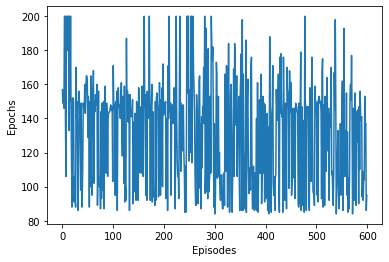

In [13]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Epochs")
plt.plot(range(episodes), total_epochs)

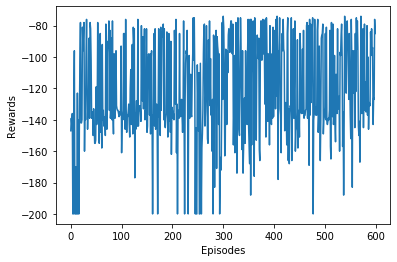

In [14]:
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.plot(range(episodes), total_rewards)

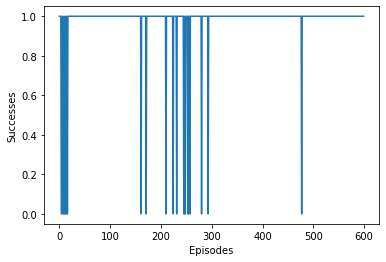

In [15]:
successes = []
for t in total_rewards:
    if t > -200:
        successes.append(1)
    else:
        successes.append(0)

plt.xlabel("Episodes")
plt.ylabel("Successes")
plt.plot(range(len(successes)), successes)

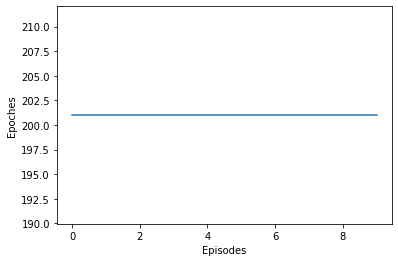

In [8]:
import matplotlib.pyplot as plt

plt.xlabel("Episodes")
plt.ylabel("Epoches")
plt.plot(range(trials), epochs)

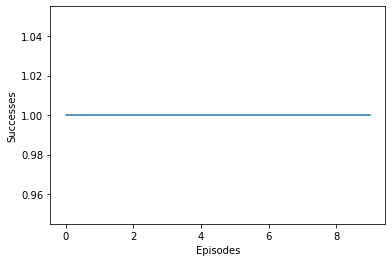

In [9]:
plt.xlabel("Episodes")
plt.ylabel("Successes")
plt.plot(range(len(successes)), successes)

In [5]:
pippo.play("trained_model.h5", 10, render=True)

___Model Loaded___
Completed/Episodes 1/10, success = 0
Completed/Episodes 2/10, success = 1
Completed/Episodes 3/10, success = 1
Completed/Episodes 4/10, success = 1
Completed/Episodes 5/10, success = 1
Completed/Episodes 6/10, success = 1
Completed/Episodes 7/10, success = 0
Completed/Episodes 8/10, success = 1
Completed/Episodes 9/10, success = 1
Completed/Episodes 10/10, success = 1


([201, 201, 201, 201, 201, 201, 201, 201, 201, 201],
 [0, 1, 1, 1, 1, 1, 0, 1, 1, 1])